In [1]:
from xraycam.nbinit import *
camcontrol.set_detector('zwo')
from xraycam.camalysis import *

In [2]:
class Monitor:
    def __init__(self, *args, transpose = True, vmax = 150, rebin = 1, **kwargs):
        self.run = camcontrol.DataRun(*args, **kwargs)
        self.vmax = vmax
        self.rebin = rebin

    def frame(self):
        return self.run.get_frame()
    
    def update(self):
        self.run.show(vmax = self.vmax)
        self.run.plot_lineout(rebin = self.rebin)
        self.frame().plot_histogram(xmin = 0, xmax = self.vmax)
        
    def stop(self):
        self.run.stop()

#### code for runset arrays

In [4]:
from xraycam.camcontrol import _rebin_spectrum

In [5]:
def rebin_spc(arr2d,rebin=5):
    lineout = np.sum(arr2d,axis=0)/110
    return _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]

In [16]:
def _reorient_array(arr2d):
    """Take output from the get_array() method for dataruns from the new camera,
    and reorient them to match what our usual analysis code expects."""
    return np.transpose(arr2d[::,::-1])

NOTe to self Will: you changed the fitregionx on the below function definition because center_of_masses was throwing NaN

fitregionmode='man',fitregionx=[500,800]

In [15]:
def plot_with_energy_scale_arr2d(arr2d,known_energy,known_bin=None, photon_value=110,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False, label=None,calcfwhm=False,parabolic=False,**kwargs):
    if parabolic == False:
        lineout = np.sum(arr2d[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=0)/photon_value
    else:
        lineout = get_parabolic_lineout(arr2d,yrange=yrange)[xrange[0]:xrange[1]]/photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,known_bin=known_bin,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    camcontrol.plt.plot(*lineout_energyscale,label=label)
    if show == True:
        camcontrol.plt.show()
    return lineout_energyscale

Note to self: need to fix the get_parabolic_lineout portion of this function.  See below.  Only works when cropping upper regions of the sensor because the fitregion needs to have the same x index range as the shape passed into parabolic_sort

In [7]:
def plot_with_energy_scale_arr2d_test(arr2d,known_energy,known_bin=None, photon_value=110,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False, label=None,calcfwhm=False,parabolic=False,**kwargs):
    if parabolic == False:
        lineout = np.sum(arr2d[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=0)/photon_value
    else:
        lineout = get_parabolic_lineout(arr2d,yrange=yrange,fitregionmode='man',fitregiony=yrange)[xrange[0]:xrange[1]]/photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,known_bin=known_bin,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    camcontrol.plt.plot(*lineout_energyscale,label=label)
    if show == True:
        camcontrol.plt.show()

don't need the function right beneath this anymore (had to make specific to zns to get it to work temporarily)

In [8]:
def plot_with_energy_scale_arr2d_zns(arr2d,known_energy,photon_value=110,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False, label=None,calcfwhm=False,parabolic=False,**kwargs):
    if parabolic == False:
        lineout = np.sum(arr2d[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=0)/photon_value
    else:
        lineout = get_parabolic_lineout(arr2d,yrange=yrange,fitregionmode='man',fitregionx=[537-150,537+150])[xrange[0]:xrange[1]]/photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    camcontrol.plt.plot(*lineout_energyscale,label=label)
    if show == True:
        camcontrol.plt.show()

In [9]:
def cropping_tool_arr2d(datarun,step,known_energy=2014,calcfwhm=True,**kwargs):
    [plot_with_energy_scale_arr2d(datarun,known_energy,label='['+','.join((str(i),str(i+step)))+']',yrange=[i,i+step],
                            show=False,calcfwhm=calcfwhm,**kwargs) for i in range(0,2000,step)]
    camcontrol.plt.show()

# PKalpha

In [3]:
gaprunset1 = camcontrol.RunSet(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            prefix = '9.21.gaprunset1',htime="5m",number_runs=24)

Loaded from cache.


In [8]:
labGaP =  np.transpose(np.genfromtxt('PKalpha_SampleCompare.8.19.csv', delimiter=',')[1:,(0,2)])
vx,vy = labGaP
labGaP = np.array([[*vx],[*vy/max(vy)]])

In [3]:
GaP2 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = 'GaP2.9.16',htime="5m")

Loaded from cache.


In [10]:
GaP2arr=_reorient_array(GaP2.run.get_array())

In [11]:
gaparr = _reorient_array(np.sum([x.get_array() for x in gaprunset1.dataruns],axis=0))

In [12]:
plt.plot(*labGaP,label='Moxtek')
plot_with_energy_scale(GaP2.run,2014.06,known_bin=None,label='Varian',rebin=3,
                           yrange=[900,1200],show=False,calcfwhm=False,peaknormalize=True,parabolic=False)
plot_with_energy_scale_arr2d(gaparr,2014.06,label="ALS - parab",yrange=[0,-1],parabolic=True,rebin=5,show=False,calcfwhm=False,peaknormalize=True)
#plot_with_energy_scale_arr2d(gaparr,2014.06,label="ALS - col",parabolic=False,rebin=5,show=False,calcfwhm=False,peaknormalize=True)
plt.show()

In [50]:
from matplotlib.pyplot import matshow

<IPython.core.display.Javascript object>


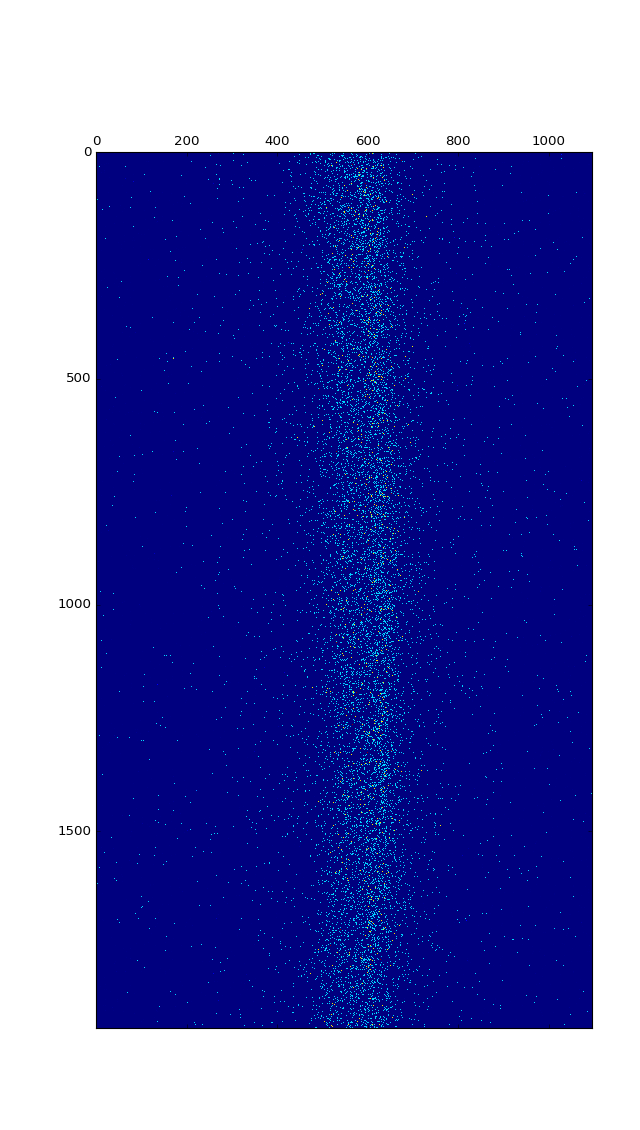

<IPython.core.display.Javascript object>


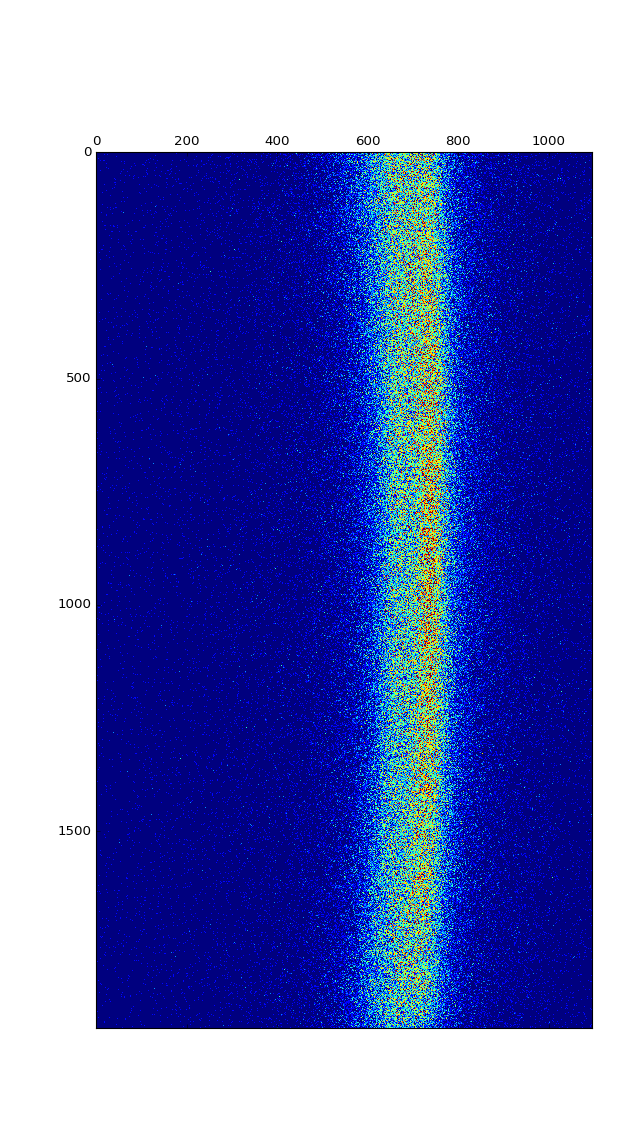

In [109]:
matplotlib.pyplot.figure(num=2,figsize=(8,8*1936/1096))
matplotlib.pyplot.figure(num=3,figsize=(8,8*1936/1096))
matplotlib.pyplot.matshow(gaparr,fignum=2,vmax=max(gaparr.ravel())*1/2)
matplotlib.pyplot.matshow(GaP2arr,fignum=3,vmax=max(GaP2arr.ravel())*1/2)
matplotlib.pyplot.show()

In [132]:
cropping_tool_arr2d(gaparr,400,calfwhm=False,rebin=5,peaknormalize=True)

In [131]:
cropping_tool(GaP2.run,400,rebin=3)

#### compare count rates

In [18]:
np.mean([x.counts_per_second() for x in gaprunset1.dataruns])

7.9803082475809992

In [62]:
GaP2.run.counts_per_second()

4390.3506775873566

## SKalpha Import ALS data

In [26]:
zns4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.zns4')
zns4.run.theta=115

Loaded from cache.


In [27]:
znsrunset0 = camcontrol.RunSet(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            prefix = '9.22.znsrunset0',htime="5m",number_runs=24)

Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.


In [30]:
znsarr0=_reorient_array(np.sum([x.get_array() for x in znsrunset0.dataruns],axis=0))

In [31]:
znsarrtotal=_reorient_array(zns4.run.get_array())+znsarr0

In [67]:
zns_lineout = plot_with_energy_scale_arr2d(znsarrtotal,2307.7,label="zns",rebin=2,yrange=[0,1300],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)

## Import Moridata

In [32]:
moridata =  np.genfromtxt('moriData_ZnSKalpha.csv', delimiter=',')

## Import Labdata (taken with Varian)

In [33]:
labdata = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'zns0.contd.9.15')

Loaded from cache.


# Analysis code

gaussian broadening code

In [34]:
def bwev(datarun,i):
    return datarun[i+1,0]-datarun[i,0]

In [35]:
def gauss_broaden(datarun,fwhm):
    pointspacing = bwev(datarun,10)
    sigma=fwhm/(2*np.sqrt(2*np.log(2)))
    f = int(sigma/pointspacing)
    d = np.transpose(datarun)
    dx, dy = d
    return np.array([gfilt(dx,f),gfilt(dy,f)/max(gfilt(dy,f))])

delta function test of gauss_broaden algorithm

In [36]:
def deltafunc(w):
    arr = np.append(np.append(np.zeros(int(w/2)),1),np.zeros(int(w/2-1)))
    energy_arr = np.arange(2012,2013,1/w)
    return np.array([[*energy_arr],[*arr]])

In [18]:
plt.plot(*gauss_broaden(np.transpose(deltafunc(1000)),0.25),label='test')
plt.show()

#### compare count rates

In [54]:
zns4.run.counts_per_second()

7.2984205828871831

In [56]:
np.mean([x.counts_per_second() for x in znsrunset0.dataruns])

7.2796437638699265

#### now compare ALS data to broadened MoriData

In [77]:
#plt.plot(*np.transpose(moridata),label='Mori')
#plt.plot(*gauss_broaden(moridata,0.5),label='Mori - '+str(0.5)+' eV')
plt.plot(*zns_lineout,label='ALS')
plot_with_energy_scale(labdata.run,2307.7,label="Varian",rebin=2,yrange=[500,1000],calcfwhm=False,show=False,peaknormalize=True)
plt.show()

# Compare focusing procedure lab/synchrotron

In [3]:
sulfurposition0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurposition0')
sulfurposition0.run.theta=30
sulfurposition0.run.z=0

KeyboardInterrupt: 

In [4]:
sulfurposition1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurposition1')
sulfurposition1.run.theta=30
sulfurposition1.run.z=6

Loaded from cache.


In [5]:
sulfurposition2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurposition2')
sulfurposition2.run.theta=30
sulfurposition2.run.z=-6

Loaded from cache.


In [6]:
sulfurposition3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurposition3')
sulfurposition3.run.theta=30
sulfurposition3.run.z=11

Loaded from cache.


In [7]:
[plot_with_energy_scale(x.run,2307.7,known_bin=None,label=str(round(x.run.z*0.35,2))+"mm",rebin=2,yrange=[0,-1],calcfwhm=False,show=False,peaknormalize=True,parabolic=True)
    for x in (sulfurposition0,sulfurposition1,sulfurposition2,sulfurposition3)]
plt.show()

Lab data at different distances

In [11]:
numlist=list(range(3,10))
focuslist = [Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus%d.9.15'%i) for i in numlist]
zlist=[0,2,4,-2,-1,0,1]
for i, monitor in enumerate(focuslist):
    monitor.run.z=zlist[i]

Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.


data isn't good enough for the comparison.  will retake ZnS data at different distances

In [12]:
[plot_with_energy_scale(x.run,2307.7,known_bin=None,label=str(x.run.z)+"mm",rebin=3,yrange=[800,1200],calcfwhm=False,show=False,peaknormalize=True,parabolic=False)
    for x in focuslist]
plt.show()

# Investigating change in signal for sample rotation

In [3]:
sulfurangleposition0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurangleposition0')
sulfurangleposition0.run.theta=30
sulfurangleposition0.bestplotparameters={'yrange':[400,1600],'rebin':4,'label':'theta=30'}

sulfurangleposition2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurangleposition2')
sulfurangleposition2.run.theta=25
sulfurangleposition2.bestplotparameters={'yrange':[800,1200],'rebin':4,'label':'theta=25'}

slist=(sulfurangleposition0,sulfurangleposition2)

Loaded from cache.


KeyboardInterrupt: 

In [5]:
def plot_default(monitor,**kwargs):
    plot_with_energy_scale(monitor.run,2307.7,known_bin=530,calcfwhm=False,show=False,peaknormalize=True,**kwargs)

In [6]:
def calc_vertex(arr2d):
    a,b,c = quadfit(arr2d)
    vertexx = -b/(2*a)
    vertexy = a*vertexx**2+b*vertexx+c
    return (vertexx,vertexy)

In [7]:
def generate_parabola(a,b,c,length=1936):
    x = np.arange(length)
    y = -a*x**2-b*x-c
    return np.array([x,y])

In [8]:
sarr0 = np.transpose(sulfurangleposition0.run.get_array())
sarr2 = np.transpose(sulfurangleposition2.run.get_array())

#### The problem

In [258]:
[plot_default(x,**x.bestplotparameters) for x in slist]
plt.show()

The same sample at 2 different angles gives signal at 2 different energies, with a shift of ~0.25eV. Note that this is a $\textbf{column}$ lineout, so it isn't a problem with the parabolic fitting algorithm.

Hypothesis 1:  A cockeyed crystal placement causes a different effective Rowland circle depending on the height of the illuminated spot out of the Rowland plane.  A back-of-the-envelope calculation suggests that in order to see a ~36um(10px) shift in placement of the signal, for a change in distance out of Rowland plane of 1mm, a 2deg tilt would be needed. Perhaps that's reasonable..

Hypothesis 2: systematic change in flux at various energies due to unequal filling of the cones?? seems fishy maybe... but note below that the count rate is indeed quite different.  A lab study can help confirm this.

Hypothesis 3:  If the camera is off circle, and we have pt source illumination, then a lateral shift in sample spot could change the location of the signal on the camera.

In [260]:
[x.run.counts_per_second() for x in slist]

[14.881422594413491, 23.341593601097767]

#### Other directions considered

It was thought that perhaps the shifting of the parabola caused by the shifting height of the sample spot, but the following considerations show that this is not the case.

Plot of center of masses of images with parabolic fits:

In [272]:
[plt.plot(*generate_parabola(*quadfit(x))) for x in (sarr0,sarr2)]
[cmplot(x,smooth=20,show=False) for x in slist]
plt.show()

In [278]:
[calc_vertex(x) for x in (sarr0,sarr2)]

[(1330.1372603460177, -547.96203562678727),
 (1626.108785985781, -559.71024813611359)]

The vertex of the parabola is shifted by ~12 pixels (~0.5eV) in the energy dispersive direction.  Thus it appears the effect is not due to the shift in height of sample spot alone.

Important note: width of the parabola seems different.  As reflected in the leading coefficient of the parablic fit.

In [277]:
[quadfit(x) for x in (sarr0,sarr2)]

[(1.0920381159651907e-05, -0.029051211755267311, -528.64098601984563),
 (1.6634652701349393e-05, -0.054099509818972706, -515.72440401903577)]

# ___
# Various calculations below

In [117]:
import matplotlib.pyplot as mplt

In [270]:
mplt.plot(*generate_parabola(*quadfit(sarr0)))
mplt.plot(*generate_parabola(*quadfit(sarr2)))

<IPython.core.display.Javascript object>


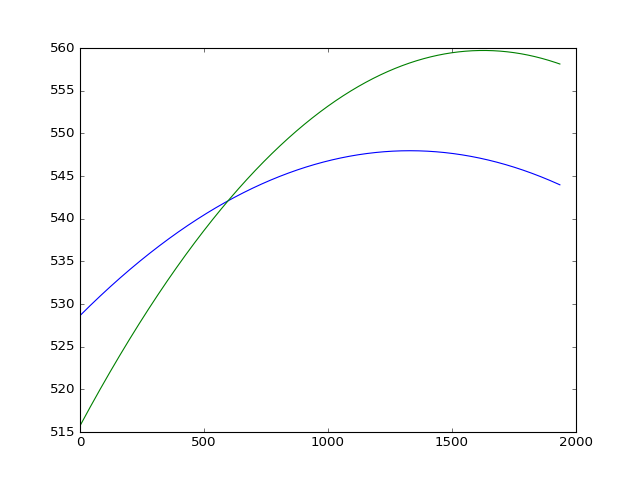

In [139]:
mplt.show()

In [271]:
plt.show()

<IPython.core.display.Javascript object>


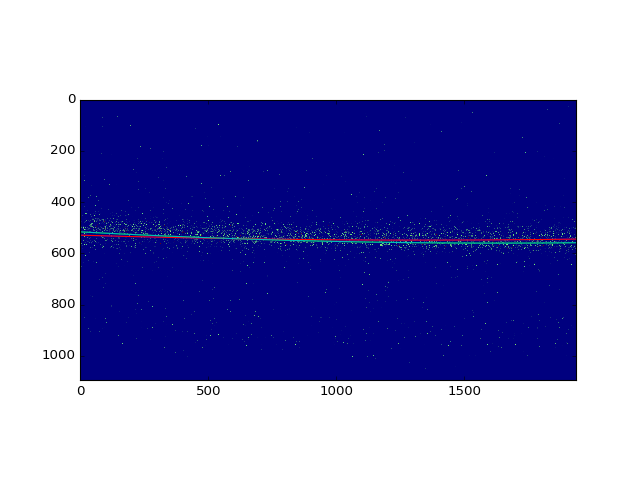

In [269]:
[plt.imshow(x.run.get_array(),vmax=250) for x in [sulfurangleposition2]]
plt.show()

In [26]:
cropping_tool(sulfurangleposition2.run,400,known_energy=2307,rebin=4,calcfwhm=False)

In [195]:
plt.plot(*generate_parabola(*quadfit(sarr0)))
plt.plot(*generate_parabola(*quadfit(sarr2)))

In [56]:
np.mean(center_of_masses(sarr2))-np.mean(center_of_masses(sarr0))

4.1839640688488089

In [168]:
def cmplot(datarun, smooth=5,xrange=[400,600], show=True):
    arr2d = np.transpose(datarun.run.get_array())[:,xrange[0]:xrange[1]]
    print(arr2d.shape)
    y = center_of_masses(arr2d)+xrange[0]
    x = np.arange(len(y))
    if smooth != 0:
        y = gfilt(y,smooth)
    plt.plot(x, y, label = 'CM lineout')
    if show == True:
        plt.show()

In [197]:
cmplot(sulfurangleposition2,smooth=20,xrange=[400,600],show=False)
cmplot(sulfurangleposition0,smooth=20,xrange=[400,600],show=False)
plt.show()

(1936, 200)
(1936, 200)


In [172]:
def range_test(datarun, smooth=5,xrange=[400,600], show=True):
    arr2d = np.transpose(datarun.run.get_array())[:,xrange[0]:xrange[1]]
    plt.imshow(arr2d)
    plt.show()

<IPython.core.display.Javascript object>


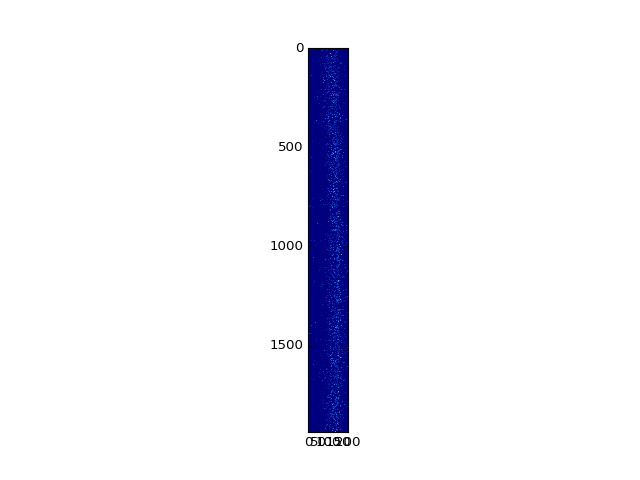

In [173]:
range_test(sulfurangleposition0)

In [284]:
quadfit(np.transpose(sulfurangleposition0.run.get_array())[:,400:600])

(1.2522729950903577e-05, -0.030310024353097199, -114.43324772887313)

In [285]:
quadfit(np.transpose(sulfurangleposition2.run.get_array())[:,400:600])

(1.4456494401541312e-05, -0.048026499792217264, -103.46726116990966)

In [286]:
quadfit(np.transpose(sulfurangleposition0.run.get_array())[:,:])

(1.0920381159651907e-05, -0.029051211755267311, -528.64098601984563)

In [287]:
quadfit(np.transpose(sulfurangleposition2.run.get_array())[:,:])

(1.6634652701349393e-05, -0.054099509818972706, -515.72440401903577)

In [191]:
def bandwidth(peak_energy,pxwidth):
    return energy_from_x_position(calc_bragg_angle(2307),pxwidth)-energy_from_x_position(calc_bragg_angle(2307),0)

In [236]:
bandwidth(2307,10)

-0.40209547683298297

In [198]:
quadfit(np.transpose(sulfurangleposition0.run.get_array())[:,400:600])

(1.2522729950903577e-05, -0.030310024353097199, -114.43324772887313)

In [279]:
parabolic_sort?

In [8]:
z,_ = parabolic_sort(1.25e-05,-0.0303,shape=(1936,1024))

In [9]:
from scipy import stats

<IPython.core.display.Javascript object>


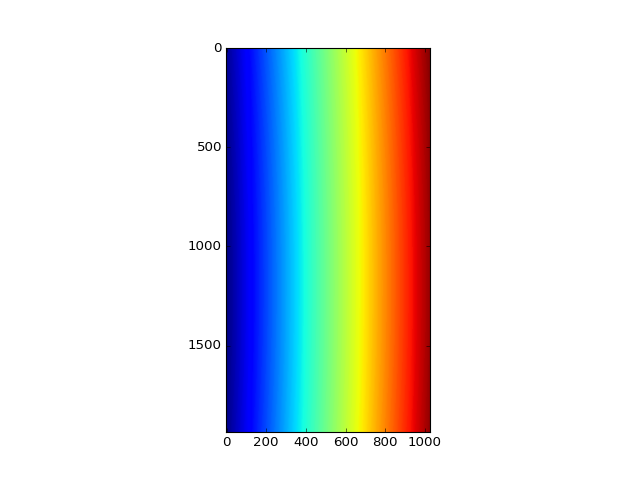

In [10]:
plt.imshow(z)
plt.show()

<IPython.core.display.Javascript object>


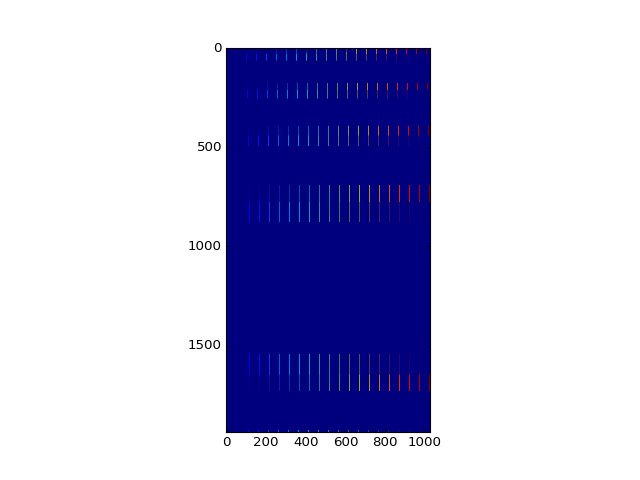

In [13]:
plt.imshow(np.sum([stats.threshold(z,threshmin=i,threshmax=i+1,newval=0) for i in range(100,1200,50)],axis=0))
plt.show()

In [11]:
np.sum([stats.threshold(z,threshmin=i,threshmax=i+10,newval=0) for i in [100,200]],axis=0)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [218]:
i=100

In [226]:
reduce?

Object `reduce` not found.


In [227]:
np.reduce?

Object `np.reduce` not found.


In [295]:
z[200:210,200:210]

array([[ 194.44     ,  195.44     ,  196.44     ,  197.44     ,
         198.44     ,  199.44     ,  200.44     ,  201.44     ,
         202.44     ,  203.44     ],
       [ 194.4147125,  195.4147125,  196.4147125,  197.4147125,
         198.4147125,  199.4147125,  200.4147125,  201.4147125,
         202.4147125,  203.4147125],
       [ 194.38945  ,  195.38945  ,  196.38945  ,  197.38945  ,
         198.38945  ,  199.38945  ,  200.38945  ,  201.38945  ,
         202.38945  ,  203.38945  ],
       [ 194.3642125,  195.3642125,  196.3642125,  197.3642125,
         198.3642125,  199.3642125,  200.3642125,  201.3642125,
         202.3642125,  203.3642125],
       [ 194.339    ,  195.339    ,  196.339    ,  197.339    ,
         198.339    ,  199.339    ,  200.339    ,  201.339    ,
         202.339    ,  203.339    ],
       [ 194.3138125,  195.3138125,  196.3138125,  197.3138125,
         198.3138125,  199.3138125,  200.3138125,  201.3138125,
         202.3138125,  203.3138125],
       [ 1

In [12]:
plt.plot(z[:,1])
plt.show()

In [17]:
plot_with_energy_scale_arr2d?

In [33]:
from xraycam.camcontrol import _rebin_spectrum

In [59]:
x, y = plot_with_energy_scale_arr2d(_reorient_array(sulfurangleposition0.run.get_array()),2307,label='s',rebin=1)

In [22]:
y

array([ 0.        ,  0.        ,  1.17272727, ...,  0.        ,
        0.        ,  0.        ])

In [138]:
def get_peaks(lineout,interp=True,**kwargs):
    """Get location of peaks using PeakUtils package.
    Format should be lineout=[energies,intensities].
    Returns [peaks_x,peaks_y].
    Peaks_x location is optionally improved using interpolation.
    Interpolation is hard-coded for Gaussian.  Can be modified for centroid, others."""
    
    #Import peak-detection package if not already loaded.
    import peakutils
    
    #Get thres and min_dist for peak-detection, set default if not provided
    thres = kwargs.get('thres',0.75)
    min_dist = kwargs.get('min_dist',30)
    width = kwargs.get('width',10)
    
    #Find peak indices
    x, y = lineout
    indexes = peakutils.indexes(y,thres=thres,min_dist=min_dist)
    peaks_x, peaks_y = lineout[0][indexes], lineout[1][indexes]
    
    #Improve peak location by fitting function locally around detected peaks in the data.  Default is gaussian.
    if interp == True:
        peaks_x=[]
        peaks_y=[]
        for i in indexes:
            a,b,c = peakutils.peak.gaussian_fit(x[int(i-width):int(i+width)],y[int(i-width):int(i+width)],center_only=False)
            peaks_x.append(b)
            peaks_y.append(a)

    return np.array([peaks_x,peaks_y])

In [152]:
class ParabolicFit:
    
    def __init__(self,datarun):
        try:
            self.run = datarun.run
        except AttributeError:
            self.run = datarun
            
    
            
    

In [148]:
print(type(sulfurangleposition0.run))

<class 'xraycam.camcontrol.DataRun'>


In [156]:
ParabolicFit(sulfurangleposition0.run).run.get_array()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [158]:
sulfurangleposition0.run.plot_lineout()

array([ 0.        ,  0.        ,  1.02380952, ...,  0.        ,
        0.        ,  0.        ])

# Testing code changes

In [4]:
GaP2 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = 'GaP2.9.16',htime="5m")

Loaded from cache.


<IPython.core.display.Javascript object>


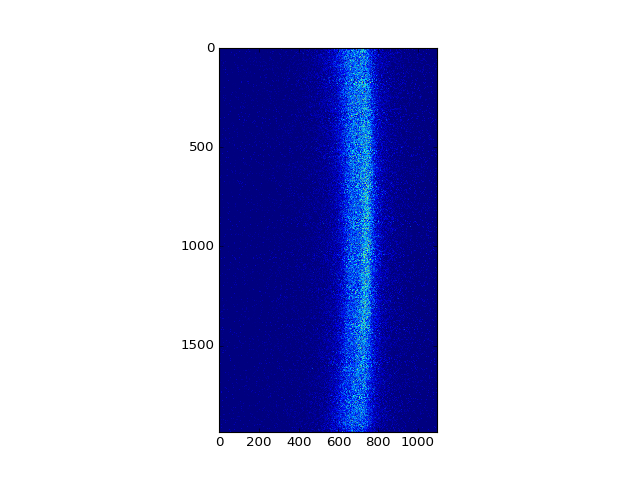

In [7]:
GaP2.run.show()

In [12]:
plt.plot(*GaP2.run.get_frame().get_lineout(energy=(2014,200),rebin=2))
plt.plot(*GaP2.run.get_frame().get_lineout(energy=(2014,None),rebin=1,yrange=[800,1200]))
plt.show()

In [12]:
GaP2.run.get_frame().data

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0, 108,   0]], dtype=uint32)